# Dino Bektesevic Exoplanets HW2

February 6th 2019



In [1]:
using PyPlot;
using CSV;
using Statistics;
using Optim;

## 1. Derive the formula for area of overlapping circles

### 1.1 Deriving the formula

This is going to be a bit dificult because sketching is dificult in a notebook and I thought of plotting the situation but I'm not going to try to rediscover how to use matplotlib through Julia that seems to hide all the methods away. 

The general approach is as follows:

* find intersection points
* express the height from the cord to the further point of the circular arc it defines
* because then we can apply the formula for the area of a circular segment to calculate the areas of individual segments that share that same coord (where h is the height of the triangle defined by the cord):
$$A(R,h) = R^2\arccos\frac{h}{R} - h\sqrt{R^2-h^2}$$
* the total area is then just the sum of the two individual circular segment areas

So lets start from the equations of two circles centered on the one with larger radius. 
$$\begin{eqnarray}
x^2+y^2 &=& R^2 \\
(x-d)^2+y^2 &=& R^2
\end{eqnarray}$$

expressing $y$ from first one an plugging into the second and then expanding

$$\begin{eqnarray}
(x-d)^2 + (R^2-x^2) &=& r^2 \\
x^2-2xd+d^2 + R^2 - x^2 &=& r^2 \\
2dx + d^2 &=& r^2 - R^2 \\
x &=& -\frac{r^2 - R^2 -d^2}{2d}
x &=& \frac{R^2 + d^2 - r^2}{2d} 
\end{eqnarray}$$

So what this essentially gives us are the two points of intersection between the circles. What we want is the distance between the vertical line through those two points and the circle origins. For the two cirles in question this is:

$$\begin{eqnarray}
h_1 &=& x =  \frac{R^2 + d^2 - r^2}{2d} \\
h_2 &=& d-x =  \frac{r^2 + d^2 - R^2}{2d} \\
\end{eqnarray}$$

The total area is then 

$$\begin{eqnarray}
A_1(R,h_1) &=& R^2\arccos\frac{x}{R} - x\sqrt{R^2-x^2} \\
    &=& R^2\arccos\frac{R^2 + d^2 - r^2}{2dR} - \frac{R^2 + d^2 - r^2}{2d}\sqrt{R^2 - \left(\frac{R^2 + d^2 - r^2}{2d}\right)^2} \\
A_2(r,h_2) &=& r^2\arccos\frac{d-x}{r} - (d-x)\sqrt{r^2-(d-x)^2} \\
    &=& r^2\arccos\frac{r^2 + d^2 - R^2}{2dr} - \frac{r^2 + d^2 - R^2}{2d}\sqrt{r^2 - \left(\frac{r^2 + d^2 - R^2}{2d}\right)^2} \\
A_{total} &=& A_1 + A_2
\end{eqnarray}$$

### 1.2 Implementing the derived equations

In [2]:
"""
Calculates the area of overlapping circular segment of the circle with radius R for for two circles with 
radii R and r separated by distance d.
Provided distance d must be a valid distance such that the circles are indeed overlapped.
"""
function circSegment(d, R, r)
    frac = (R.^2 .+ d.^2 .- r.^2)./(2 .* d)
    return R.^2 .* acos.(frac./R) .- frac.*sqrt.(R.^2 .- frac.^2)
    end;

"""
Wraps circular segment calculation to return the overlapped area of the larger circle for two circles with 
radii r and R separated by distance d.
Provided distance d must be a valid distance such that the circles are indeed overlapped.
"""
function A1(d; r=0.1, R=1)
    return circSegment(d, R, r)
    end;
    
"""
Wraps circular segment calculation to return the overlapped area of the smaller circle for two circles with 
radii r and R separated by distance d.
Provided distance d must be a valid distance such that the circles are indeed overlapped.
"""
function A2(d; r=0.1, R=1)
    return circSegment(d, r, R)
    end;

"""
Calculates the total overlapping area as a sum of the individual overlapped areas of circles with radii
R and r separated by distance d.
Provided distance d must be a valid distance such that the circles are indeed overlapped.
"""
function Atot(d; r=0.1, R=1)
    return A1(d, r=r, R=R) .+ A2(d, r=r, R=R)
    end;

"""
Evaluates the valid range of distances in left->right order where the circles are overlapped and evaluates 
the total overlapped area for each of the valid distances. Left to right motion is assumed and overlapping
area is normalized from 0 to maximal overlap on the left-hand side and from maximal overlap to 0 on the
right-hand side.
"""
function createIngresEgresProfiles(R, r; step=0.001, returnRange=false)
    d = range(-R-r, r-R, step=step)
    d2 = range(R-r, R+r, step=step)

    ingres = Atot(d, r=r, R=R)
    egres = Atot(d2, r=r, R=R)
    
    if returnRange
        return pi*(R^2+r^2) .- ingres, egres, d, d2
        end;
    return pi*(R^2+r^2) .- ingres, egres
    end;

### 1.3 Validating the sensibility of implementation.

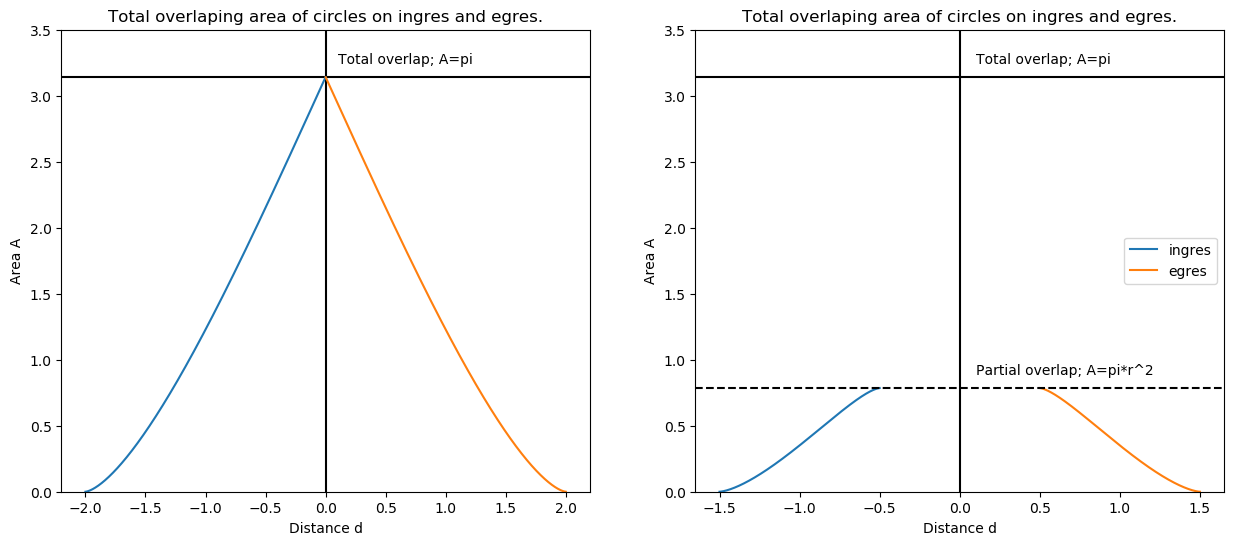

In [3]:
in1, eg1, di1, de1 = createIngresEgresProfiles(1, 1, returnRange=true)
in2, eg2, di2, de2 = createIngresEgresProfiles(1, 0.5, returnRange=true)

fig, axes = subplots(1, 2, figsize=(15, 6))

for (ax, i, e, di, de) in zip(axes, [in1, in2], [eg1, eg2], [di1, di2], [de1, de2])
    ax[:axhline](pi, color="black")
    ax[:axvline](0, color="black")
    
    ax[:plot](di, i, label="ingres");
    ax[:plot](de, e, label="egres");

    ax[:set_title]("Total overlaping area of circles on ingres and egres.")
    ax[:set_xlabel]("Distance d")
    ax[:set_ylabel]("Area A")
    ax[:text](0.1, pi+0.1, "Total overlap; A=pi")
    
    ax[:set_ylim](0, 3.5)
    end;

axes[2][:axhline](pi*0.5^2, color="black", ls="--")
axes[2][:text](0.1, pi*0.5^2+0.1, "Partial overlap; A=pi*r^2")

legend();

## 2. Implement a transit light curve model with no limb darkening

There are multiple different phases to a transit curve:

* no transit, when we see stellar flux
* limb transiting, when we decrease the stellar flux according to the overlapping area
* disk transiting, when the total surface area of the planet is blocking the stellar flux

which are repeated in inverse order on egress. We already have ingress and egress overlapping area calculations implemented but we lack the disk transit and no transit phase.

In [4]:
"""
For a given distance, or a range of distances, d evaluates the total overlapped area of circles with
radii R and r. Wraps the ingres and egres profiles code above such that the evaluation can happen 
even over a domain where the analytic expression for total overlapped area is not defined. 
"""
function transitModelArea(d, R, r)
    model = zeros(length(d))
    
    transitMask = findall(x-> abs(x)<=abs(R-r) , d)
    ingresMask  = findall(x-> (x<0) & ( abs(x)<abs(R+r) ) & ( abs(x)>abs(R-r) ), d)
    egresMask   = findall(x-> (x>0) & ( abs(x)<abs(R+r) ) & ( abs(x)>abs(R-r) ), d)
    
    constA(x) = pi*r^2
    
    model[ingresMask]  .= pi*(R^2+r^2) .- Atot(d[ingresMask], r=r, R=R)
    model[egresMask]   .= Atot(d[egresMask], r=r, R=R)
    model[transitMask] .= constA(d[egresMask])

    return model
    end;

function transitModelArea(d::Number, R, r)
    if (abs(d)<abs(R+r)) & (abs(d)>abs(R-r))
        if d<=0
            # ingres
            return pi*(R^2+r^2) .- Atot(d, r=r, R=R)
            end;
        # egres
        return Atot(d, r=r, R=R)
    elseif (abs(d)<=abs(R-r))
        return pi*r^2
    else
        return 0;
        end;
    end;

"""
For a given range of distances d evaluates the fraction of obstructed flux from the larger circle, 
normalized to 1, as the ratio of area obstructed by the smaller circle, with radius r, and the total 
area of the larger circle, with radius R.
"""
function transitFlux(d, R, r)
    return 1 .- (transitModelArea(d, R, r) ./ (pi*R^2))
    end;

### 2.1 Validate sensibility of the transit model

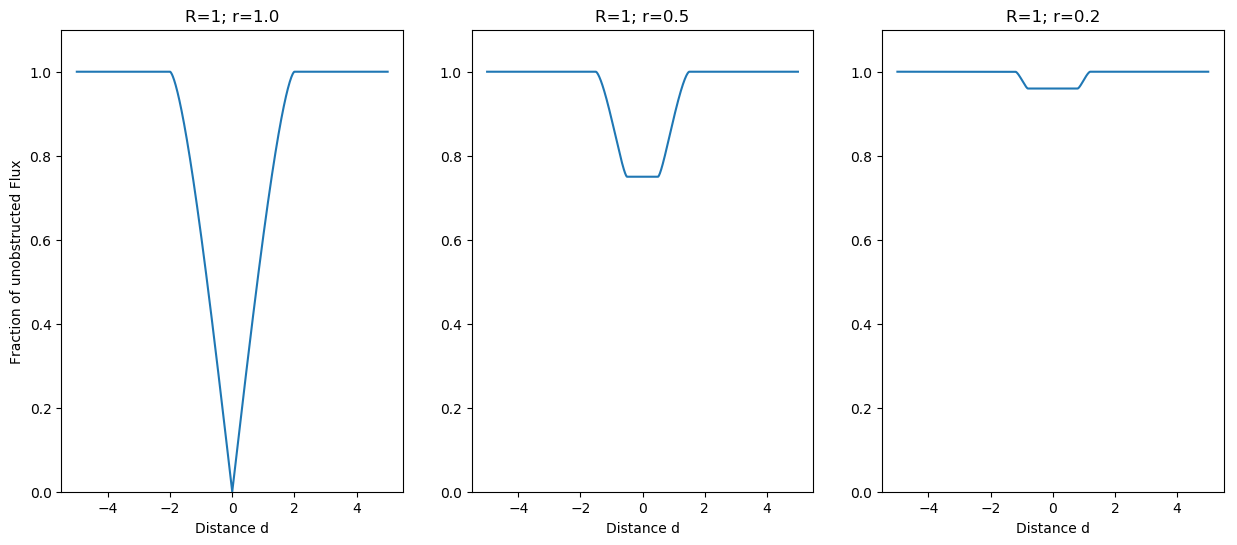

In [5]:
fig, axes = subplots(1, 3, figsize=(15, 6))

d = range(-5, 5, step=0.01)
r = [1, 0.5, 0.2]
m1 = transitFlux(d, 1, r[1])
m2 = transitFlux(d, 1, r[2])
m3 = transitFlux(d, 1, r[3])

for (ax, m, t) in zip(axes, [m1, m2, m3], r)
    ax[:plot](d, m)
    ax[:set_title]("R=1; r=$t")
    ax[:set_xlabel]("Distance d")
    ax[:set_ylim](0, 1.1)
    end;

axes[1][:set_ylabel]("Fraction of unobstructed Flux");

## 3. Use the layered-cake prescription to produce a transit profile with limb darkening.

### 3.1 Define the intensity profiles 

In [6]:
"""Calculates the stellar disk intensity I(r'<R_{star}) at a radius r using the radially symetric 
linear limb darkening model.
"""
function linearI(x, R; coeff=1)
    if abs(x)<R
        mu = sqrt(1 - x^2)
        return  (1 - coeff*(1 - mu))
    else
        return 0;
        end;
    end;

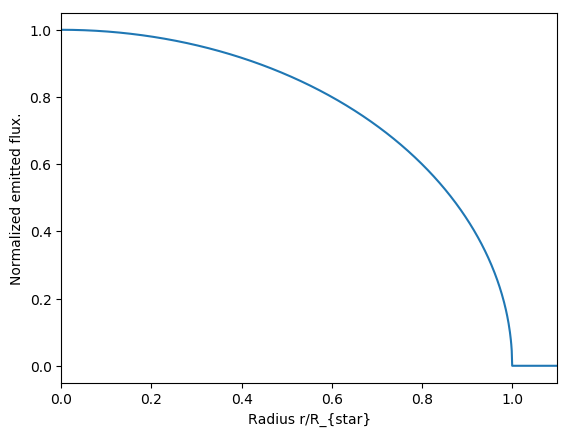

In [7]:
d = range(-2, 2, step=0.001)
plot(d, linearI.(d, 1))
xlim(0, 1.1)
xlabel("Radius r/R_{star}")
ylabel("Normalized emitted flux.");

### 3.2 Implement a transit light curve model with limb darkening

I could vecorize this but I suspect no real advantage to that exists in Julia and it is easier to reason about this calculation in a more linear for-loop way. Additionally, because I have not followed the batman paper the limb darkening calculations are very sensitive to roundoff errors because a lot of equations have not gone through the required substitutions to make them more numerically stable. To implement that now would require uglifying a lot of the above code so I did not do that.

In [8]:
"""
For a given range of distances d evaluates the fraction of obstructed flux from the larger circle, 
not normalized, as the ratio of area obstructed by the smaller circle, with radius r, and the total 
area of the larger circle, with radius R, weighted by the intensity profile across the disk of the
larger circle.
"""
function transitFluxLimbDarkened(d, R, r; dr=0.05, intensityf=linearI)
    subdivs = range(0, R, step=dr);
    subdivs = subdivs[2:end];
    midpoints = (subdivs[2:end] .+ subdivs[1:end-1]) ./ 2;
    I = intensityf.(midpoints, R);
    
    totF = zeros(length(d))
    
    for (i,dd) in enumerate(d)
        shellFs = zeros(length(subdivs))
        for (j,starR) in enumerate(subdivs)
            shellFs[j] = transitFlux(dd, r, starR)
            end;
        dShellFs = shellFs[2:end] - shellFs[1:end-1]
        totF[i] = sum(I .* dShellFs)+1
        end;
        
    return totF;        
    end;

### 3.3 Validate the sensibility of the limb darkened profile.

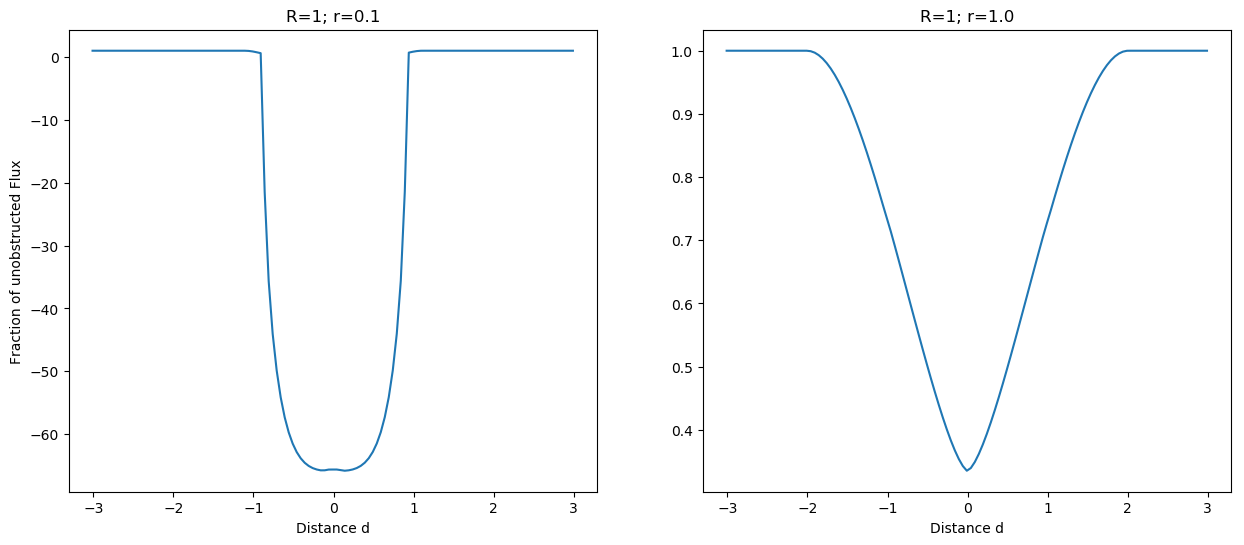

In [9]:
R=1; r = [0.1, 1];
d = range(-3.01, 3, step=0.05)
        
fig, axes = subplots(1, 2, figsize=(15, 6))

m1 = transitFluxLimbDarkened(d, R, r[1])
m2 = transitFluxLimbDarkened(d, R, r[2])

for (ax, m, t) in zip(axes, [m1, m2, m3], r)
    ax[:plot](d, m)
    ax[:set_title]("R=$R; r=$t")
    ax[:set_xlabel]("Distance d")
    #ax[:set_ylim](0, 1.1)
    end;

axes[1][:set_ylabel]("Fraction of unobstructed Flux");

## 4. Fit the transit data.

Fitting is done via following steps:
* find the best-fit period via folding
* fold the data onto the found period
* use the more stable no limb darkening model to find the remaining transit parameters by a brute force grid search

### 4.1 Read the file with measuraments

In [10]:
"Reads the file pointed to by path and separates the columns using the given delimiter"
function readDataFile(path, delim="\t")
    t = Float64[];
    y = Float64[];
    sigma = Float64[];
    for row in CSV.File(path, delim=delim)
        push!(t, row.t);
        push!(y, row.y);
        push!(sigma, row.sigma);
        end;
    return t, y, sigma;
    end;

### 4.2 Implement period folding

In [11]:
"Uses modulus operations to calculate folded time-stamps."
function foldOnT(t, t_fold)
    return t .% t_fold
    end;

"Sorts the given times, values and errors on times."
function sortByTime(t, y, sigma)
    tSortedIndx = sortperm(t);
    return t[tSortedIndx], y[tSortedIndx], sigma[tSortedIndx];
    end;

### 4.3 Implement a $\chi^2$ fitter to find which folded period works best

In [12]:
"Folds on provided period and sorts on the given arrays to produce a periodogram."
function makePeriodogram(t, y, sigma, P)
    ts = foldOnT(t, P)
    return sortByTime(ts, y, sigma)
    end;

"Calculates the moving average by binning N consecutive data points"
function movingAvg(t, y, N)
    tt=[]; yy=[]; s=[]; 
    for i in range(0, length(t), step=N)
        if i+N > length(t)
            break
            end;
        push!(tt, mean(t[i+1:i+N]))
        push!(yy, mean(y[i+1:i+N]))
        end;
    return tt, yy;
    end;  

"""
Smooths the given data points by calculating the moving average over N points, selects only those smoothed
points that are below the given confidence cutoff and then sums the squares of distances of the smoothed 
data points to that cutoff.
"""
function sumDist(t, y; N=50, confidence=3)
    tt, mavg = movingAvg(t, y, N)
    
    avg = mean(y)
    std = Statistics.std(mavg)
    conflvl = avg - confidence*std
    
    indices = findall(x-> x<conflvl, mavg)
    if isempty(indices) 
        summ = -0.5
    else
        summ = sum(abs.(mavg[indices].-conflvl))
    end;
        
    return summ;
    end;

"""
Finds the best fitting period. Given the start and end times and the time step tests a range of 
smoothed, time folded, data to find the period with largest distance metric.  
"""
function findPeriod(t, y, sigma; start=9, endt=10, stept=0.01, N=50, confidence=3)
    minP = -1; minDist = -1;
    
    for (i, testP) in enumerate(start:stept:endt)
        testT, testY, testErr = makePeriodogram(t, y, sigma, testP)
        dist = sumDist(testT, testY, N=N, confidence=confidence)
        if dist > minDist
            minP = testP
            minDist = dist
            end;
        end;
        
    print("Minimal found P: $minP")
    return minP;
    end;

### 4.4 Fit the data for period.

In [13]:
t, y, sigma = readDataFile("mystery_planet2.txt");

N = 10
confidence = 3

period = findPeriod(t, y, sigma, stept=0.001, N=N, confidence=confidence);

Minimal found P: 9.791

### 4.5 Plot the folded periods and verify

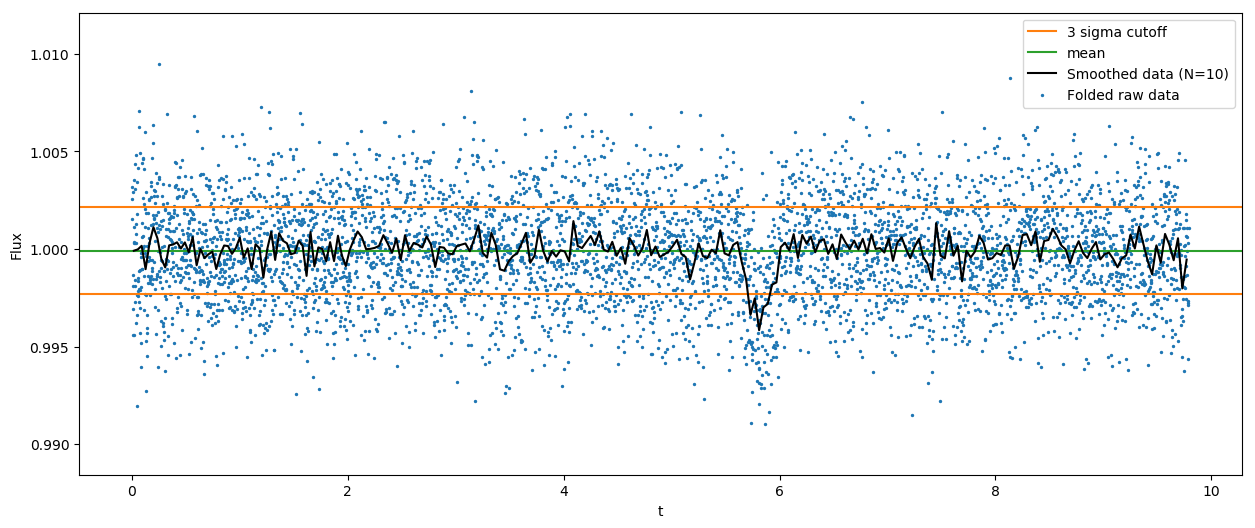

In [14]:
fig, axes = subplots(figsize=(15, 6))

foldedt, foldedf, foldedsigmas = makePeriodogram(t, y, sigma, period)
smootht, smoothy = movingAvg(foldedt, foldedf, 20)

avg = mean(y)
std = Statistics.std(smoothy)

scatter(foldedt, foldedf, s=2, label="Folded raw data")

axhline(avg+confidence*std, color="C1", label="3 sigma cutoff")
axhline(avg-confidence*std, color="C1")
axhline(avg, color="C2", label="mean")

plot(smootht, smoothy, color="black", label="Smoothed data (N=10)");

xlabel("t")
ylabel("Flux")

legend();

### 4.6 Implement transit fitter.

In [15]:
"""
For a given folded and normalized transit data series t and y searches through the grid of parameters
to find the best fitting transit time, stellar radius and planet radius values. 
"""
function fitTransit(t, y; transitTrange=5.7:0.001:5.9, Rrange=0.1:0.001:0.2, rrange=0.005:0.0001:0.01)
    # make sure our minimums are unreasonably large
    dist = []; distmin=9999;
    ttmin=9999; rsmin=9999; rpmin=9999; 
    for tt in transitTrange
        for rs in Rrange
            for rp in rrange
                tss = t .- tt
                m = transitFlux(tss, rs, rp);
                curdist = sum((y-m).^2)
                push!(dist, curdist)
                if curdist<distmin
                    ttmin = tt
                    rsmin = rs
                    rpmin = rp
                    distmin = curdist
                    end;
                end;
            end;
        end;
    return ttmin, rsmin, rpmin, distmin
    end;

### 4.6 Fit the light-curve model.

The grid was originaly done on a larger, relatively coarser, grid of parameters which where then refined and the search was repeated on a much finer grid of parameters. This finer grid has been since set as the default setup for the transit fitting function. Fit is performed on folded not-smoothed data.

In [16]:
ttmin, rsmin, rpmin, distmin = fitTransit(foldedt, foldedf)
println("Transit time (relative to first time stamp): ", ttmin)
println("R_{star}: ", rsmin)
println("R_{planet}: ", rpmin)
println("Distance metric for the best fit: ", distmin)

Transit time (relative to first time stamp): 5.819
R_{star}: 0.158
R_{planet}: 0.0082
Distance metric for the best fit: 0.03207236772022508


### 4.7 Plot the fitted transit curve and verify sensibility.

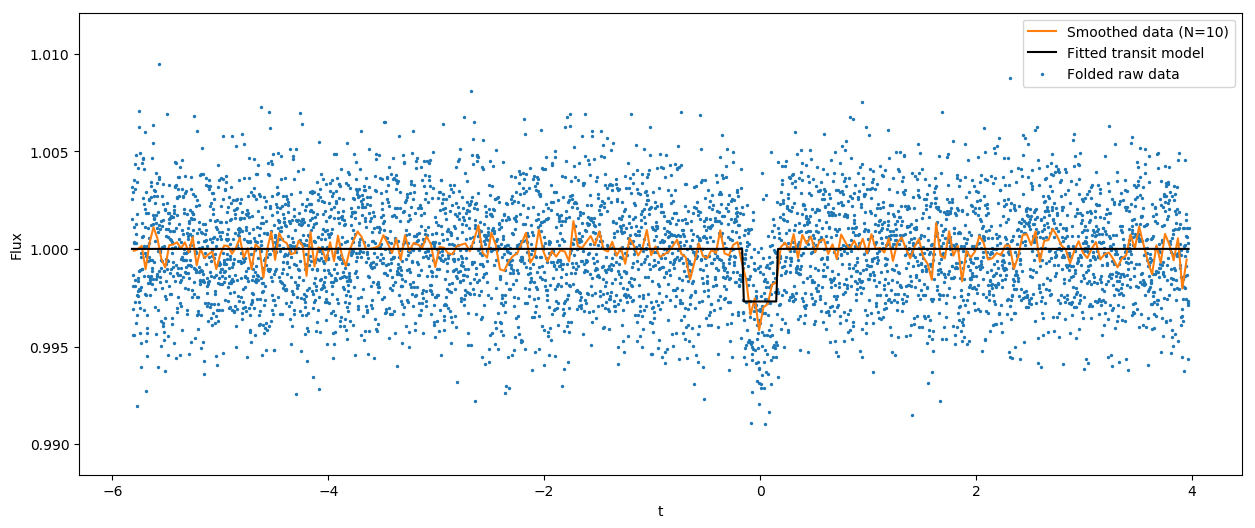

In [17]:
fig, axes = subplots(figsize=(15, 6))

tss = foldedt .- ttmin
m = transitFlux(tss, rsmin, rpmin)

scatter(tss, foldedf, s=2, color="C0", label="Folded raw data");
plot(smootht.-ttmin, smoothy, color="C1", label="Smoothed data (N=10)");
plot(tss, m, color="black", label="Fitted transit model")

xlabel("t")
legend();
ylabel("Flux");